#**1. Dataset description and preprocessing**

##*1.1 Introduction and data source*

The dataset is sourced from AIcrowd competition:
https://www.aicrowd.com/challenges/epfl-ml-road-segmentation/dataset_files. It contains 100 aerial images acquired from GoogleMaps with corresponding ground-truth images where each pixel is labeled as {road, background}.

The goal is to train a classifier to segment roads in these images, i.e. assign a label {road=1, background=0} to each pixel.


##*1.2 Data augmentation*

Because we have fewer observations, we need to  synthesize new training examples by copying and manipulating the images we've already got. We rotate and shift original aerial  images and label images simultaneoulsy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from PIL import Image
import os

def rotate_images(input_dir, output_dir):
    # Loop through each file in the directory
    for file_name in os.listdir(input_dir):
        # Check if the file is an image file
        if file_name.endswith('.jpg') or file_name.endswith('.png'):
            # Open the image file
            img_path = os.path.join(input_dir, file_name)
            img = Image.open(img_path)

            # Perform the desired transformations on the image
            # Rotate the image by 90 degrees
            img = img.rotate(90)

            # Create the output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)

            # Save the transformed image to a new file
            new_file_name = file_name[:-4] + '_rotated.png'
            new_img_path = os.path.join(output_dir, new_file_name)
            img.save(new_img_path)

def shift_images(input_dir, output_dir, shift_pixels):
    # Loop through each file in the directory
    for file_name in os.listdir(input_dir):
        # Check if the file is an image file
        if file_name.endswith('.jpg') or file_name.endswith('.png'):
            # Open the image file
            img_path = os.path.join(input_dir, file_name)
            img = Image.open(img_path)

            # Perform the desired transformations on the image
            # Shift the image horizontally by the specified pixels
            img = img.transform(
                img.size,
                Image.AFFINE,
                (1, 0, shift_pixels, 0, 1, 0)
            )

            # Create the output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)

            # Save the transformed image to a new file
            new_file_name = file_name[:-4] + f'_shifted_{shift_pixels}.png'
            new_img_path = os.path.join(output_dir, new_file_name)
            img.save(new_img_path)

# Rotate aerial images
rotate_images('/content/drive/MyDrive/training/images', '/content/drive/MyDrive/training/images final')

# Rotate label images
rotate_images('/content/drive/MyDrive/training/groundtruth', '/content/drive/MyDrive/training/groundtruth final')

# Shift aerial images horizontally by 80 pixels
shift_images('/content/drive/MyDrive/training/images', '/content/drive/MyDrive/training/images final', 80)

# Shift label images horizontally by 80 pixels
shift_images('/content/drive/MyDrive/training/groundtruth', '/content/drive/MyDrive/training/groundtruth final', 80)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/training/images'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##*1.3 Importing library and loading dataset*

After data augmentation, we copied synthesized ones into original folder and loaded the whole dataset, created two datasets with batch size 1 and did not shuffle them. After that, we zipped images and labels together, shuffled them and split into train and validation dataset.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as im #load images from files, and to create new images.
from IPython.display import Image #Create a PNG/JPEG/GIF image object given raw data.

In [ ]:
#import images from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
from PIL import Image

base_path = ('/content/drive/MyDrive/')

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset

train_dataset = image_dataset_from_directory(base_path + 'training/images final', label_mode=None, batch_size=1,image_size=(400, 400), shuffle=False)
labels_dataset = image_dataset_from_directory(base_path + 'training/groundtruth final',label_mode = None, batch_size=1,image_size=(400, 400), shuffle=False, color_mode='grayscale')

# zipping
zipped_ds = Dataset.zip((train_dataset, labels_dataset))

for image,label in zipped_ds:
  print(image.shape)
  print(label.shape) # We have grayscale images but they are just going to be the same array replicated 3 times.
  break

zipped_ds = zipped_ds.shuffle(400) # Shuffle over our 100 image-segmentation mask pairs.

train_ds = zipped_ds.take(320) # First 240 images to go training
validation_ds = zipped_ds.skip(320) # Last 240 images go to validation.

Found 400 files belonging to 1 classes.
Found 400 files belonging to 1 classes.
(1, 400, 400, 3)
(1, 400, 400, 1)


In [ ]:
print("Training Dataset Size:", len(train_ds))
print("Validation Dataset Size:", len(validation_ds))



Training Dataset Size: 320
Validation Dataset Size: 80


In [ ]:
for image, label in train_ds.take(3):
    print("Training Sample - Image Shape:", image.shape, "Label Shape:", label.shape)

for image, label in validation_ds.take(3):
    print("Validation Sample - Image Shape:", image.shape, "Label Shape:", label.shape)


Training Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)
Training Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)
Training Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)
Validation Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)
Validation Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)
Validation Sample - Image Shape: (1, 400, 400, 3) Label Shape: (1, 400, 400, 1)


##*1.4 Histogram of data*

We plotted histograms of pixel values in aerial images and label images. We found that pixel values in label images centers on 0 and 237, with a few noises around them, and there is an imbalance within them, with nearly 75% of 0s.



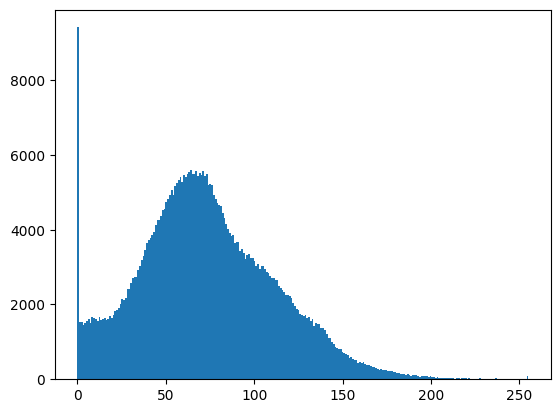

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

for image, label in train_ds:
  train_images = image
  train_labels = label
  train_vector = np.reshape(image[0],-1)
  label_vector = np.reshape(label[0],-1)
  plt.hist(train_vector, bins=256)
  plt.title="Histogram of Pixel Values"
  plt.show()
  break

In [ ]:
pd.DataFrame(train_vector).describe()

,0
count,480000.000000
mean,73.114494
std,38.880917
min,0.000000
25%,47.000000
50%,70.000000
75%,98.000000
max,255.000000


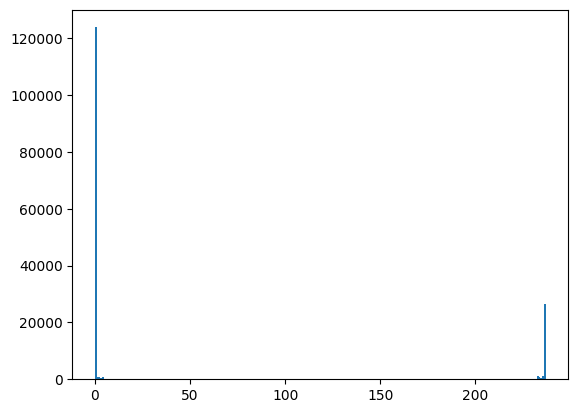

,0
count,160000.000000
mean,46.770287
std,93.185501
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,237.000000


In [ ]:
plt.hist(label_vector, bins=255)
plt.title="Histogram of Pixel Values"
plt.show()
pd.DataFrame(label_vector).describe()

##*1.5 Visualisation of train image and its label*

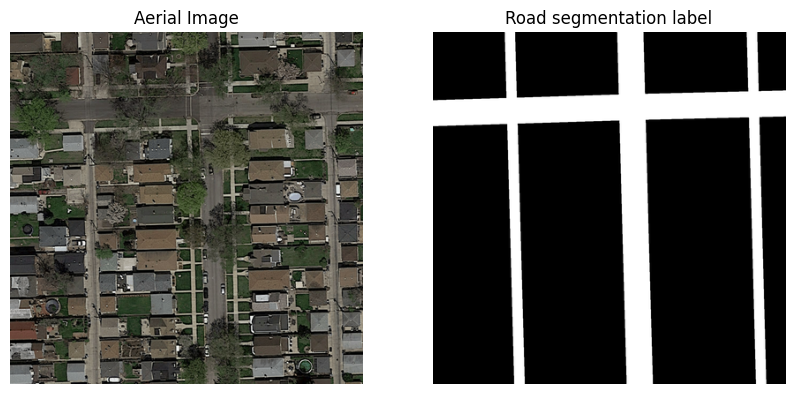

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(train_images[0]/255)
ax2.imshow(train_labels[0]/255,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation label')

# Show the figure
plt.show()

##*1.6 Rescaling and bucketing labels' pixels to 0 or 1*

In [ ]:
from tensorflow import keras
# Create rescale layer
rescale_layer = keras.layers.Rescaling(scale=1./237)

# Create custom bin boundaries
bin_boundaries = [0.5]
# Create discretization layer with custom bin boundaries
discretization_layer = keras.layers.Discretization(bin_boundaries=bin_boundaries)


train_ds = train_ds.map(
    lambda x, y: (x, discretization_layer(rescale_layer(y))))

validation_ds = validation_ds.map(
    lambda x, y: (x, discretization_layer(rescale_layer(y))))

In [ ]:
print(len(train_ds))
print(len(validation_ds))


320
80


#**2. Model 1: Simple Dense NN**

##*2.1 Setting Model Configuration*

In the dense NN model, we first used a rescaling layer to convert the values into floats with a range 0 - 1, then flattened the input arrays into a vector, after that there are two dense layers with units of 256 each and relu as activation function, then a sigmoid activation to predict the output lable. In the end, we reshaped them back into 400*400 pixel grayscale image.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(400,400,3,)),
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(160000, activation="sigmoid"),
    layers.Reshape((400,400,1))
])

Next, we will indicate some configuration parameters. In particular, what optimization algorithm to use (RMSProp), what loss function to use (binary cross-entropy because we have binary outcome variables), and what metric to optimize on (accuracy).

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 256)               122880256 
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 160000)            41120000  
                                                                 
 reshape (Reshape)           (None, 400, 400, 1)       0         
                                                                 
Total params: 164,066,048
Trainable params: 164,066,048


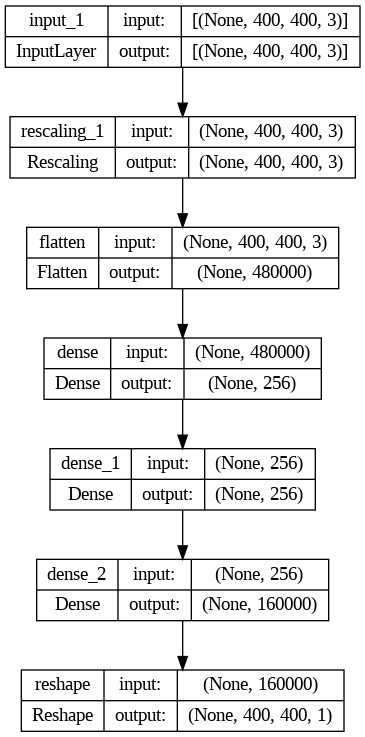

In [ ]:
#Plot the model flowchart
keras.utils.plot_model(model, show_shapes=True)

##*2.2 Fitting the model and plotting the accuracy and loss*

In [ ]:
print(len(train_ds))
print(len(validation_ds))


320
80


In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=50,shuffle=True)

Epoch 1/50
320/320 [==============================] - 24s 47ms/step - loss: 0.5104 - accuracy: 0.8040 - val_loss: 0.4864 - val_accuracy: 0.8152
Epoch 2/50
320/320 [==============================] - 18s 45ms/step - loss: 0.4856 - accuracy: 0.8191 - val_loss: 0.4778 - val_accuracy: 0.8226
Epoch 3/50
320/320 [==============================] - 25s 64ms/step - loss: 0.4779 - accuracy: 0.8183 - val_loss: 0.4703 - val_accuracy: 0.8138
Epoch 4/50
320/320 [==============================] - 26s 64ms/step - loss: 0.4701 - accuracy: 0.8198 - val_loss: 0.4659 - val_accuracy: 0.8106
Epoch 5/50
320/320 [==============================] - 26s 64ms/step - loss: 0.4658 - accuracy: 0.8181 - val_loss: 0.4482 - val_accuracy: 0.8227
Epoch 6/50
320/320 [==============================] - 21s 48ms/step - loss: 0.4626 - accuracy: 0.8199 - val_loss: 0.4444 - val_accuracy: 0.8190
Epoch 7/50
320/320 [==============================] - 18s 44ms/step - loss: 0.4556 - accuracy: 0.8193 - val_loss: 0.4417 - val_accuracy:

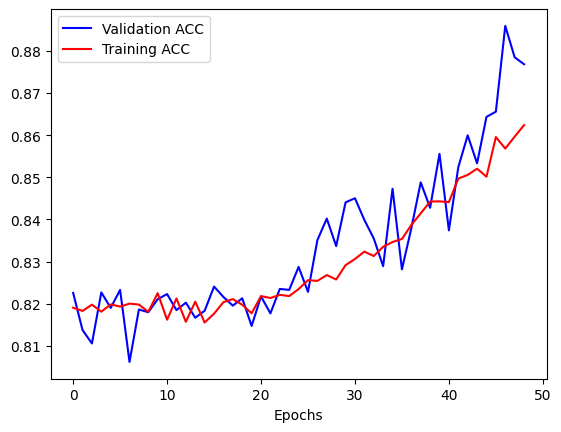

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy

plt.plot(history.history['val_accuracy'][1:],c="b")
plt.plot(history.history['accuracy'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation ACC','Training ACC'])
plt.xlabel("Epochs")
plt.show()

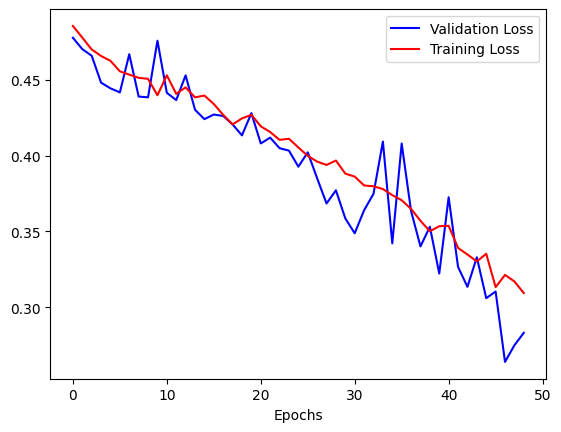

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss

plt.plot(history.history['val_loss'][1:],c="b")
plt.plot(history.history['loss'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation Loss','Training Loss'])
plt.xlabel("Epochs")
plt.show()

##*2.3 Visualising the predicted segmentation*

In [ ]:
# Let's take our batch of validation images to see the predictions
validation_images = []
validation_labels = []
for image, label in validation_ds:
  validation_images.append(image)
  validation_labels.append(label)

1/1 [==============================] - 0s 126ms/step


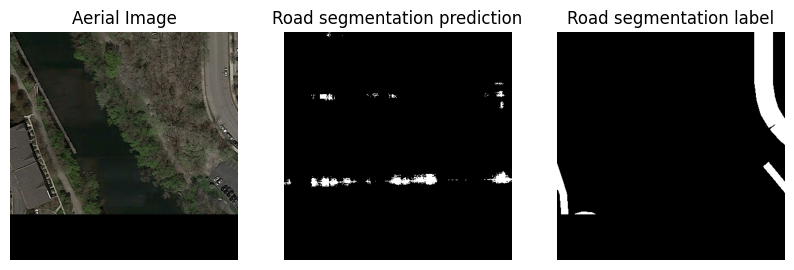

In [ ]:
segmentation = model.predict(validation_images[5])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[5])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[5])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

1/1 [==============================] - 0s 20ms/step


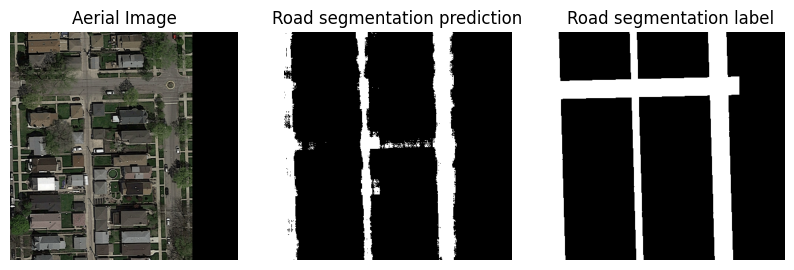

In [ ]:
segmentation = model.predict(validation_images[6])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[6])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[6])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

In [ ]:
train_labels_array=[]
train_images_array =[]
for images, labels in train_ds.unbatch():
    train_images_array.append(images)
    train_labels_array.append(labels)

validation_labels_array=[]
validation_images_array =[]
for images, labels in validation_ds.unbatch():
    validation_images_array.append(images)
    validation_labels_array.append(labels)

In [ ]:
train_images_array = np.array(train_images_array)
train_labels_array = np.array(train_labels_array)

validation_images_array = np.array(validation_images_array)
validation_labels_array = np.array(validation_labels_array)

#**3. Model 2: U-NET (2D CNN)**

##*3.1 Setting Model Configuration and model flowchart*

In [ ]:
'''
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
'''

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping


################################################################
def multi_unet_model(n_classes=1, IMG_HEIGHT=400, IMG_WIDTH=400, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Encoder portion
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    #Decoder portion
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model_unet = multi_unet_model(n_classes=1, IMG_HEIGHT=400, IMG_WIDTH=400, IMG_CHANNELS=3)
model_unet.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=["accuracy"])

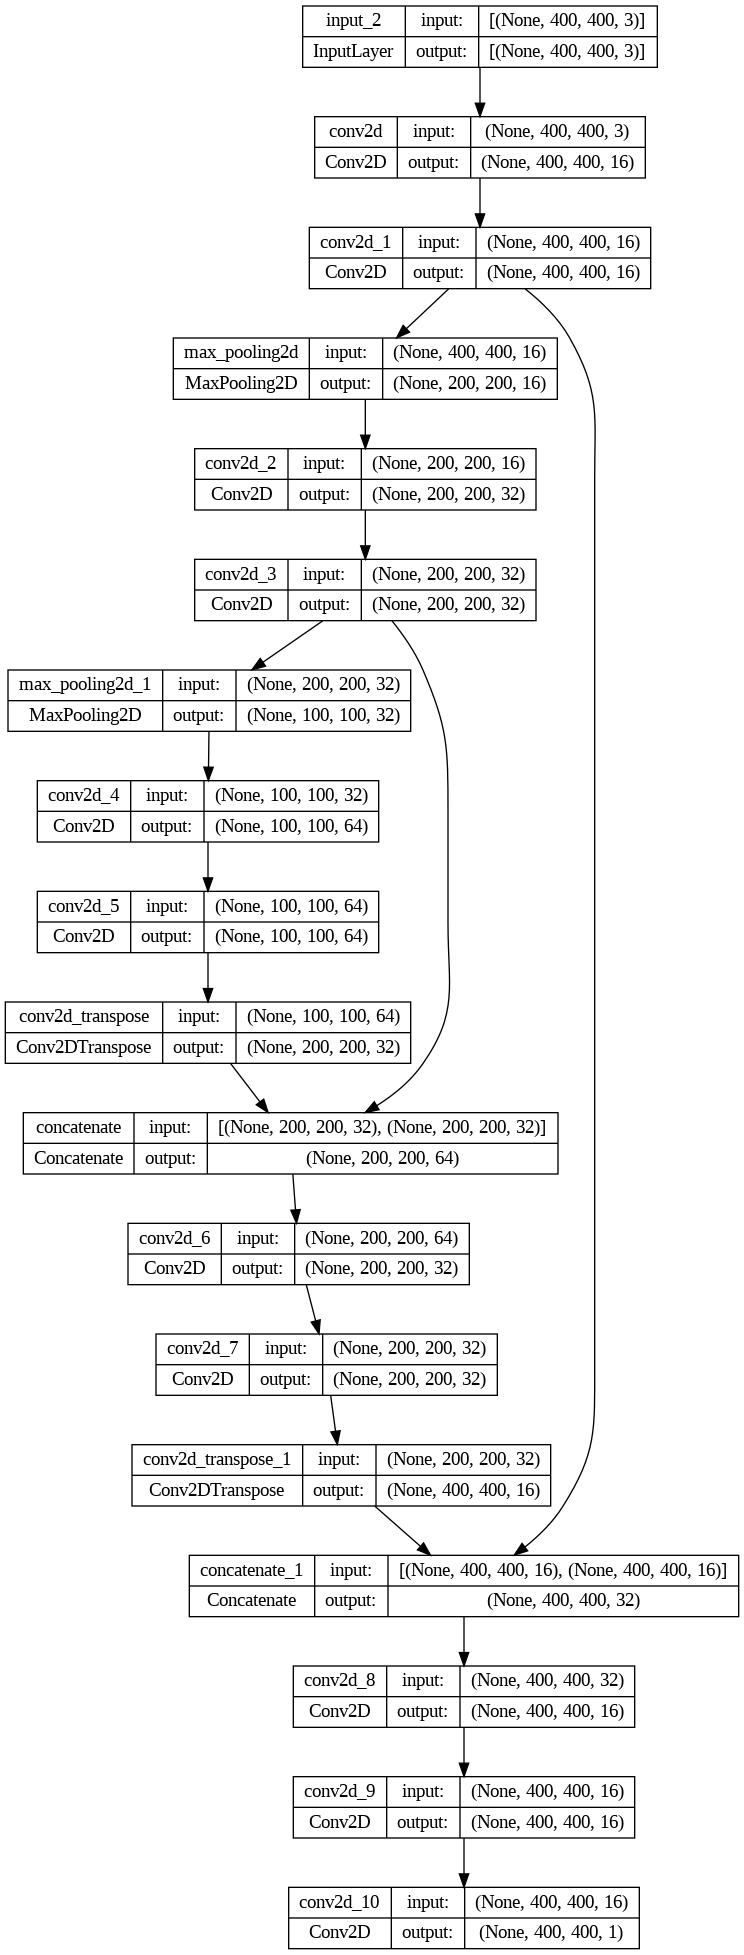

In [ ]:
# Plot the model flowchart
keras.utils.plot_model(model_unet, show_shapes=True)

##*3.2 Fitting the model and plotting the accuracy and loss*

In [ ]:
#Define callbacks
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

history = model_unet.fit(train_ds,
                    batch_size = 1,
                    verbose=1,
                    epochs=50,
                    validation_data=validation_ds,
                    shuffle=True,
                    callbacks = [early_stop])

Epoch 1/50
320/320 [==============================] - 22s 36ms/step - loss: 0.6167 - accuracy: 0.7991 - val_loss: 0.4287 - val_accuracy: 0.8151
Epoch 2/50
320/320 [==============================] - 17s 37ms/step - loss: 0.4145 - accuracy: 0.8190 - val_loss: 0.3672 - val_accuracy: 0.8255
Epoch 3/50
320/320 [==============================] - 16s 38ms/step - loss: 0.3788 - accuracy: 0.8173 - val_loss: 0.3613 - val_accuracy: 0.8234
Epoch 4/50
320/320 [==============================] - 15s 36ms/step - loss: 0.3507 - accuracy: 0.8197 - val_loss: 0.3090 - val_accuracy: 0.8145
Epoch 5/50
320/320 [==============================] - 16s 35ms/step - loss: 0.3333 - accuracy: 0.8461 - val_loss: 0.2772 - val_accuracy: 0.8756
Epoch 6/50
320/320 [==============================] - 16s 35ms/step - loss: 0.3182 - accuracy: 0.8565 - val_loss: 0.3187 - val_accuracy: 0.8621
Epoch 7/50
320/320 [==============================] - 20s 51ms/step - loss: 0.3022 - accuracy: 0.8635 - val_loss: 0.2776 - val_accuracy:

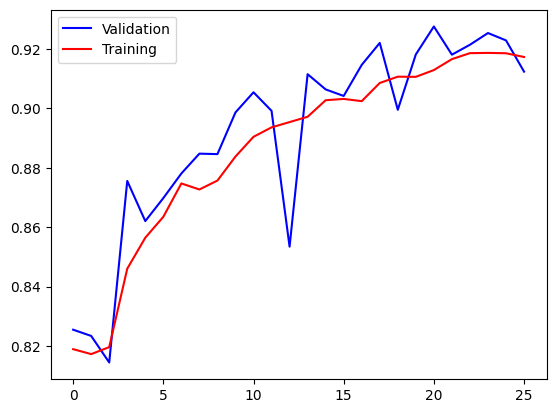

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy

plt.plot(history.history['val_accuracy'][1:],c="b")
plt.plot(history.history['accuracy'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation','Training'])
plt.show()

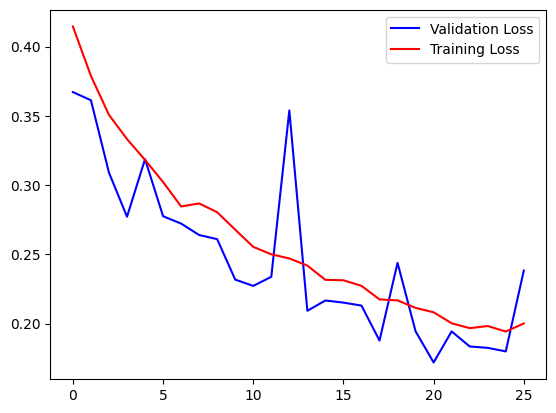

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss

plt.plot(history.history['val_loss'][1:],c="b")
plt.plot(history.history['loss'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation Loss','Training Loss'])
plt.show()

##*3.3 Visualising the predicted segmentation*

We plotted the same images as before to visualize the predicted segmentation based on U-NET model.

1/1 [==============================] - 0s 156ms/step


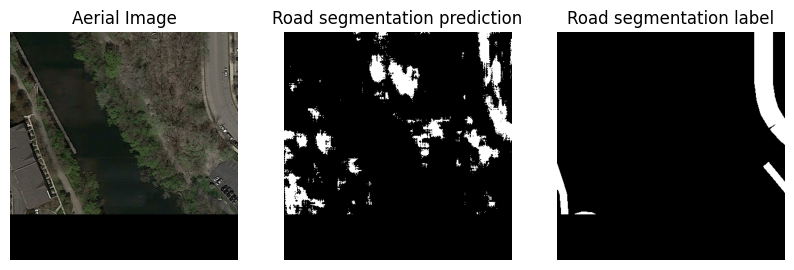

In [ ]:
segmentation = model_unet.predict(validation_images[5])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[5])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[5])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

1/1 [==============================] - 0s 21ms/step


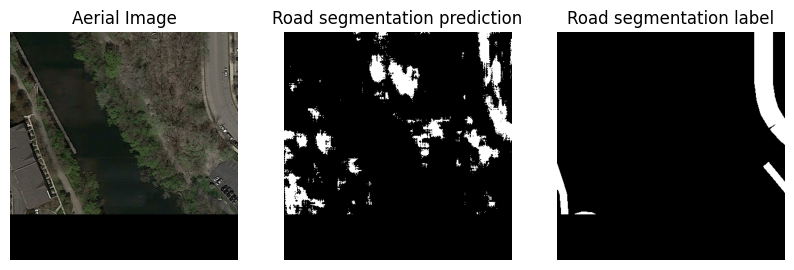

In [ ]:
segmentation = model_unet.predict(validation_images[5])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[5])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[5])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

##*3.4 Plotting Feature maps*

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []

# We are making a 'new' Keras model based on the single prior trained one, but with *many* different output branches.

# Iterate over all the layers in my prior model...
for layer in model_unet.layers:

    # If that layer is a 2D Convolution or a Max Pool layer...
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(f'Current layer is {layer.name} and its output shape is {layer.output.shape}')
        # Take that layer's outputs and name and append them to a list (we are going to use all of these as 'different' output layers, across a series of new models)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Finally, define a new model as the trained model's inputs, mapped to the list of various layer outputs we created above.
# So, the new model takes images as input, and it will spit out a list of outputs (those associated with each successive Conv2D and pooling layer)
featuremap_model = keras.Model(inputs=model_unet.input, outputs=layer_outputs)

Current layer is conv2d and its output shape is (None, 400, 400, 16)
Current layer is conv2d_1 and its output shape is (None, 400, 400, 16)
Current layer is max_pooling2d and its output shape is (None, 200, 200, 16)
Current layer is conv2d_2 and its output shape is (None, 200, 200, 32)
Current layer is conv2d_3 and its output shape is (None, 200, 200, 32)
Current layer is max_pooling2d_1 and its output shape is (None, 100, 100, 32)
Current layer is conv2d_4 and its output shape is (None, 100, 100, 64)
Current layer is conv2d_5 and its output shape is (None, 100, 100, 64)
Current layer is conv2d_transpose and its output shape is (None, 200, 200, 32)
Current layer is conv2d_6 and its output shape is (None, 200, 200, 32)
Current layer is conv2d_7 and its output shape is (None, 200, 200, 32)
Current layer is conv2d_transpose_1 and its output shape is (None, 400, 400, 16)
Current layer is conv2d_8 and its output shape is (None, 400, 400, 16)
Current layer is conv2d_9 and its output shape is

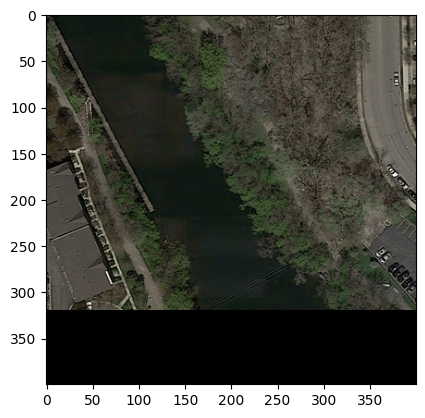

In [ ]:
plt.imshow(tf.squeeze(validation_images[5])/255)

1/1 [==============================] - 0s 247ms/step


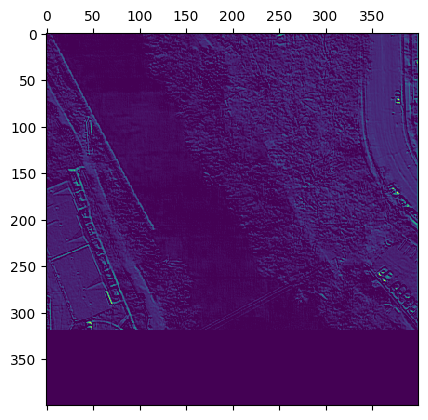

In [ ]:
import matplotlib.pyplot as plt

featuremaps = featuremap_model.predict(validation_images[5])

# What layer, and what filter do we want to look at?
layer = 0
filter = 1

# Let's plot the 1st feature map from the first Convolution layer.
# It seems to be detecting some edges.
plt.matshow(featuremaps[layer][0, :, :, filter], cmap="viridis")
plt.show()

1/1 [==============================] - 0s 19ms/step


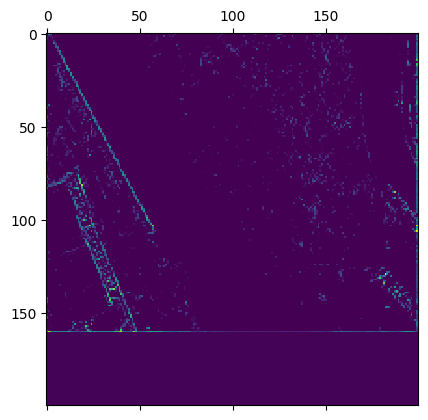

In [ ]:
import matplotlib.pyplot as plt

featuremaps = featuremap_model.predict(validation_images[5])

# What layer, and what filter do we want to look at?
# The second last layer
layer = 2
filter = 2

# Let's plot the feature map from the first Max Pool layer.
# It seems to be detecting some edges.
plt.matshow(featuremaps[layer][0, :, :, filter], cmap="viridis")
plt.show()

1/1 [==============================] - 0s 19ms/step


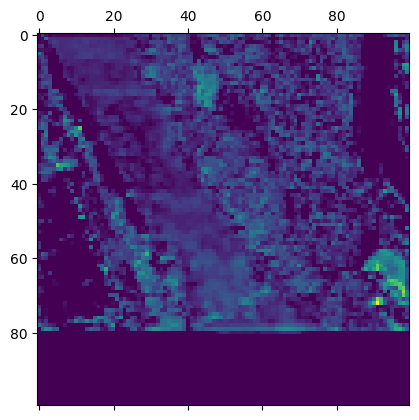

In [ ]:
import matplotlib.pyplot as plt

featuremaps = featuremap_model.predict(validation_images[5])

# What layer, and what filter do we want to look at?
layer = 5
filter = 2

# Let's plot the feature map from the second Max Pool layer.
# It seems to be detecting some edges.
plt.matshow(featuremaps[layer][0, :, :, filter], cmap="viridis")
plt.show()

#**4. Model 3: Pre-trained + U-NET**
To improve our U-NET model performance, we fine-tuned it from a pre-trained model. Here we are going to load the VGG16 convolutional base (the first 3 blocks), and actually use it inside our network (though we will freeze its parameters so we don't try to update them as we go, since that would ruin the model and add lots of computation time).

##*4.1 Setting Model Configuration*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

#Load the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # Throw away the densely connected layer at the end.
    input_shape=(400, 400, 3))

58889256/58889256 [==============================] - 0s 0us/step


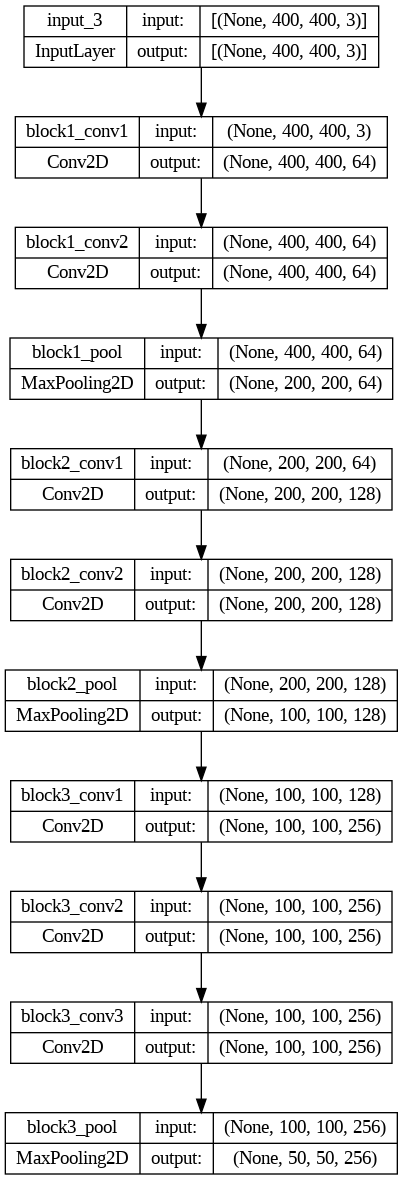

In [ ]:
#Extract the first 3 blocks of VGG16 and show what it looks like
base_model = Model(inputs = conv_base.input, outputs= conv_base.get_layer('block3_pool').output)
keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
base_model = Model(inputs = conv_base.input, outputs= conv_base.get_layer('block3_pool').output)
base_model.trainable = False
def multi_unet_model_vgg(n_classes=1, IMG_HEIGHT=400, IMG_WIDTH=400, IMG_CHANNELS=3):
#Build the model
    inputs = keras.Input(shape=(400, 400, 3))
    x = inputs
    x = keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    # Decoder portion
    x = layers.Conv2DTranspose(256, (3,3), strides=2,activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=2,activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)
    #Encoder portion
    p1 = MaxPooling2D((2, 2))(x)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    #Decoder portion
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, x], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model_unet_vgg = multi_unet_model_vgg(n_classes=1, IMG_HEIGHT=400, IMG_WIDTH=400, IMG_CHANNELS=3)
model_unet_vgg.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=["accuracy"])
model_unet_vgg.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 400, 400, 3)  0          ['input_4[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 400, 400, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                          

##*4.2 Fitting the model and plotting the accuracy and loss*

In [ ]:
history = model_unet_vgg.fit(train_ds,
                    verbose=1,
                    epochs=50,
                    validation_data=validation_ds,
                    shuffle=True)

Epoch 1/50
320/320 [==============================] - 29s 64ms/step - loss: 0.7586 - accuracy: 0.8183 - val_loss: 0.2995 - val_accuracy: 0.8769
Epoch 2/50
320/320 [==============================] - 27s 73ms/step - loss: 0.3021 - accuracy: 0.8721 - val_loss: 0.2402 - val_accuracy: 0.9019
Epoch 3/50
320/320 [==============================] - 23s 60ms/step - loss: 0.2426 - accuracy: 0.8999 - val_loss: 0.3213 - val_accuracy: 0.8758
Epoch 4/50
320/320 [==============================] - 24s 62ms/step - loss: 0.2088 - accuracy: 0.9165 - val_loss: 0.1751 - val_accuracy: 0.9293
Epoch 5/50
320/320 [==============================] - 25s 62ms/step - loss: 0.1767 - accuracy: 0.9301 - val_loss: 0.2385 - val_accuracy: 0.9115
Epoch 6/50
320/320 [==============================] - 24s 61ms/step - loss: 0.1592 - accuracy: 0.9377 - val_loss: 0.1391 - val_accuracy: 0.9479
Epoch 7/50
320/320 [==============================] - 24s 59ms/step - loss: 0.1534 - accuracy: 0.9401 - val_loss: 0.1254 - val_accuracy:

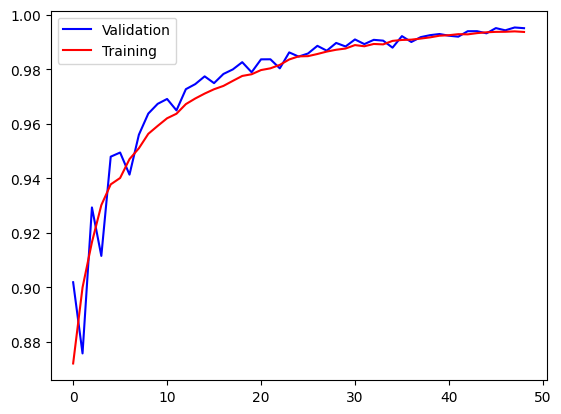

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuray

plt.plot(history.history['val_accuracy'][1:],c="b")
plt.plot(history.history['accuracy'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation','Training'])
plt.show()

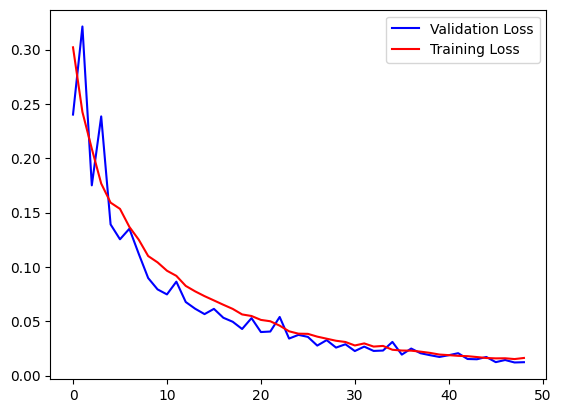

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss

plt.plot(history.history['val_loss'][1:],c="b")
plt.plot(history.history['loss'][1:],c="r")
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.legend(['Validation Loss','Training Loss'])
plt.show()

##*4.3 Visualising the predicted segmentation*


1/1 [==============================] - 0s 250ms/step


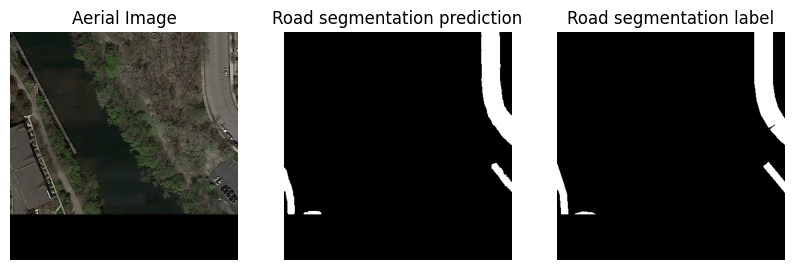

In [ ]:
segmentation = model_unet_vgg.predict(validation_images[5])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[5])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[5])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

1/1 [==============================] - 0s 22ms/step


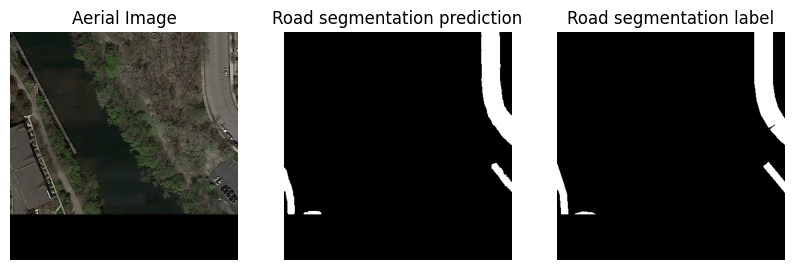

In [ ]:
segmentation = model_unet_vgg.predict(validation_images[5])
segmentation = np.where(segmentation[0] > 0.5, 1, 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Display images on the subplots
ax1.imshow(tf.squeeze(validation_images[5])/255)
ax2.imshow(np.round(segmentation),cmap="gray") # if I use np.round it cleans up the segmentation a lot!
ax3.imshow(tf.squeeze(validation_labels[5])/237,cmap="gray")

# Optionally, remove axes
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Set optional titles for subplots
ax1.set_title('Aerial Image')
ax2.set_title('Road segmentation prediction')
ax3.set_title('Road segmentation label')

# Show the figure
plt.show()

##*4.4 Grid Search*

We searched through three different filter sizes (3,3),(4,4) and (5,5) for our convolution layers. We found that for 20 epochs, (3,3) gave us the best results with an accuracy of 0.96, and this is the parameter we used previously.


In [ ]:
train_labels_array=[]
train_images_array =[]
for images, labels in train_ds.unbatch():
    train_images_array.append(images)
    train_labels_array.append(labels)

validation_labels_array=[]
validation_images_array =[]
for images, labels in validation_ds.unbatch():
    validation_images_array.append(images)
    validation_labels_array.append(labels)


In [ ]:
train_images_array = np.array(train_images_array)
train_labels_array = np.array(train_labels_array)

validation_images_array = np.array(validation_images_array)
validation_labels_array = np.array(validation_labels_array)

In [ ]:
pip install keras==2.12.0


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import keras


base_model.trainable = False
def create_model(cov_filter_size = (3,3)):

    inputs = keras.Input(shape=(400, 400, 3))
    x = inputs
    x = keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)

    # Decoder portion
    x = layers.Conv2DTranspose(256, cov_filter_size, strides=2,activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, cov_filter_size, strides=2,activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(16, cov_filter_size, strides=2, activation="relu", padding="same")(x)

    #Encoder portion
    p1 = MaxPooling2D((2, 2))(x)

    c2 = Conv2D(32, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    #Decoder portion
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Conv2D(32, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, x], axis=3)
    c5 = Conv2D(16, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(16, cov_filter_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = "rmsprop", loss = "binary_crossentropy" , metrics = ['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

gridsearch_net = KerasRegressor(build_fn= create_model, cov_filter_size = (3,3))

<ipython-input-52-55d82eecf7c6>:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gridsearch_net = KerasRegressor(build_fn= create_model, cov_filter_size = (3,3))


In [ ]:
print(gridsearch_net.get_params().keys())

dict_keys(['cov_filter_size', 'build_fn'])


In [ ]:
# suppress warnings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define parameter grid for grid search
param_grid = {
    'cov_filter_size': [(3, 3), (4, 4), (5, 5)],
}

# Create a list to store results
results = []

# Iterate over hyperparameter combinations
for params in ParameterGrid(param_grid):
    # Create and compile the model with the current hyperparameters
    model = create_model(cov_filter_size=params['cov_filter_size'])

    # Train the model
    history = model.fit(
        train_images_array, train_labels_array,
        epochs=20, validation_data=(validation_images_array, validation_labels_array),
        batch_size=1, verbose=1
    )

    # Evaluate the model on validation data
    validation_score = model.evaluate(validation_images_array, validation_labels_array, verbose=0)

    # Save the results
    results.append({
        'params': params,
        'history': history,
        'validation_score': validation_score
    })

# Find the best model based on validation score
best_result = min(results, key=lambda x: x['validation_score'])

# Print best hyperparameters and corresponding loss
print('Best hyperparameters:', best_result['params'])
print('Best validation score:', best_result['validation_score'])



In [ ]:
print(f"Best hyperparameters: {best_result['params']}")



In [ ]:
print(f"Best validation score: {best_result['validation_score']}")


In [ ]:
def calculate_iou(y_true, y_pred, smooth=1e-5):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

best_model = create_model(cov_filter_size=best_result['params']['cov_filter_size'])

# Train the best model on the entire training set
best_model.fit(train_images_array, train_labels_array, epochs=20, batch_size=1, verbose=1)

# Make predictions on the validation set
validation_predictions = best_model.predict(validation_images_array)

# Apply threshold to predictions
threshold = 0.5
binary_predictions = (validation_predictions > threshold).astype(int)

# Calculate IoU for each image
iou_values = []
for i in range(len(validation_labels_array)):
    iou = calculate_iou(validation_labels_array[i], binary_predictions[i])
    iou_values.append(iou)

# Calculate average IoU
average_iou = np.mean(iou_values)
print(f"Average IoU: {average_iou}")


In [ ]:
pip install keras==2.12.0
